<a href="https://colab.research.google.com/github/comojin1994/Deep_Learning_Study/blob/master/Kaggle/Global_Wheat_Detection/Global_Wheat_Detection_FasterRCNN_resnet50_Inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%cd ./drive/My\ Drive/Kaggle/Global_Wheat_Detection/input/global-wheat-detection/

/content/drive/My Drive/Kaggle/Global_Wheat_Detection/input/global-wheat-detection


In [0]:
# !unzip global-wheat-detection.zip

In [0]:
%cd ..

/content/drive/My Drive/Kaggle/Global_Wheat_Detection/input


In [0]:
%cd ..

/content/drive/My Drive/Kaggle/Global_Wheat_Detection


In [0]:
%cd ./output/

/content/drive/My Drive/Kaggle/Global_Wheat_Detection/output


In [0]:
!ls

Global_Wheat_Detection_FasterRCNN_resnet50fpn.ipynb
Global_Wheat_Detection_Inference.ipynb


# Module import

In [0]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import PIL
from PIL import Image

import cv2

import torch
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision import transforms

import torch.utils.data
from torch.utils.data import Dataset, DataLoader
import random

In [0]:
os.listdir('../input/global-wheat-detection')

train_dir = '../input/global-wheat-detection/train'
test_dir = '../input/global-wheat-detection/test'

df_train = pd.read_csv('../input/global-wheat-detection/train.csv')

In [0]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [0]:
def get_transform():
    list_transforms = []
    list_transforms.append(transforms.ToTensor())
    return transforms.Compose(list_transforms)

def collate_fn(batch):
    return tuple(zip(*batch))

def get_instance_objectdetection_model(num_classes, path_weight):
    create_model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, pretrained_backbone=False)
    
    in_features = create_model.roi_heads.box_predictor.cls_score.in_features
    
    create_model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    create_model.load_state_dict(torch.load(path_weight, map_location=torch.device('cpu')))
    
    return create_model

# Inference

In [0]:
path_trained_weight = '../input/fasterrcnn/customtrained_fasterrcnn_resnet50_fpn.pth'
num_classes = 2
trained_model = get_instance_objectdetection_model(num_classes, path_trained_weight)

In [0]:
class GlobalWheatDetectionTestDataset(torch.utils.data.Dataset):
  def __init__(self, input_df, input_dir, transforms=None):
    self.df = input_df
    self.list_images = list(self.df['image_id'].unique())
    self.image_dir = input_dir
    self.transforms = transforms

  def __getitem__(self, idx):
    img_id = self.list_images[idx]

    img = cv2.imread(self.image_dir + '/' + img_id + '.jpg')
    img_RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_scaled = img / 255.
    img_final = img_scaled

    if self.transforms is not None:
      img_final = self.transforms(img_final)

    return img_final, img_id

  def __len__(self):
    return len(self.df['image_id'].unique())

In [0]:
def format_prediction_string(boxes, scores): ## Define the formate for storing prediction results
    pred_strings = []
    for j in zip(scores, boxes):
        pred_strings.append("{0:.4f} {1} {2} {3} {4}".format(j[0], j[1][0], j[1][1], j[1][2], j[1][3]))

    return " ".join(pred_strings)

In [0]:
df_test = pd.read_csv('../input/global-wheat-detection/sample_submission.csv')

test_dataset = GlobalWheatDetectionTestDataset(df_test, test_dir, get_transform())

In [0]:
test_dataloader = DataLoader(
    test_dataset,
    batch_size = 8,
    shuffle = False,
    num_workers = 2,
    collate_fn = collate_fn
)

In [0]:
detection_threshold = 0.45

In [0]:
torch.cuda.empty_cache()

device = torch.device('cuda')

trained_model.eval()
trained_model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequent

In [0]:
results = []
trained_model.eval()
images = []
outputs = []
for images_, image_idx in test_dataloader:
  images = list(image.to(device, dtype=torch.float) for image in images_)
  outputs = trained_model(images)

  for i, image in enumerate(images):
    boxes = outputs[i]['boxes'].data.cpu().numpy()
    scores = outputs[i]['scores'].data.cpu().numpy()

    boxes = boxes[scores >= detection_threshold].astype(np.int32)
    scores = scores[scores >= detection_threshold]

    image_id = image_idx[i]

    boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
    boxes[:, 3] = boxes[:, 3] - boxes[:, 1]

    result = {
        'image_id': image_id,
        'PredictionString': format_prediction_string(boxes, scores)
    }

    results.append(result)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


In [0]:
test_df = pd.DataFrame(results, columns=['image_id', 'PredictionString'])
test_df.head()

,image_id,PredictionString
0,aac893a91,0.9716 615 914 76 98 0.9613 588 773 95 117 0.9...
1,51f1be19e,0.9787 761 881 152 106 0.9721 503 458 210 111 ...
2,f5a1f0358,0.9831 286 460 162 95 0.9767 141 753 158 114 0...
3,796707dd7,0.9791 895 333 109 86 0.9730 669 455 113 120 0...
4,51b3e36ab,0.9976 3 423 101 320 0.9969 234 641 94 154 0.9...


In [0]:
test_df.to_csv('submission.csv', index=False)

# Visualization

In [0]:
sample = images[1].permute(1, 2, 0).cpu().numpy()
boxes = outputs[1]['boxes'].data.cpu().numpy()
scores = outputs[1]['scores'].data.cpu().numpy()

boxes = boxes[scores >= detection_threshold].astype(np.int32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


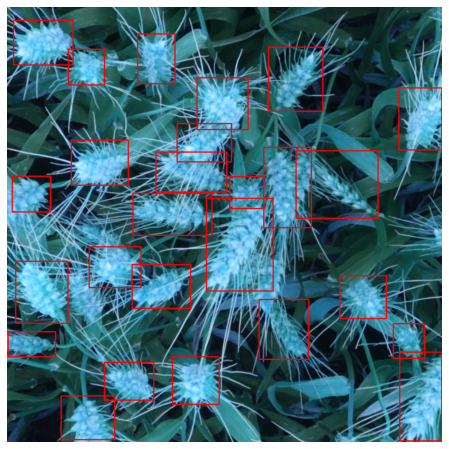

In [0]:
fig, ax = plt.subplots(1, 1, figsize = (16, 8))

for box in boxes:
  cv2.rectangle(sample, 
                (box[0], box[1]),
                (box[2], box[3]),
                (220, 0, 0), 2)
  
ax.set_axis_off()
ax.imshow(sample)